# Gentrification in New Orleans - Leah Kuperman and Leo Simanonok

https://leosimanonok.github.io/DataScienceFinalTutorial/

&nbsp;&nbsp;&nbsp;&nbsp;Throughout the past decade, data science has emerged as a leading field of study and industry. Data analysis has become critical in tackling societal problems and 
tracking certain trends in order to arrive at informed, logical solutions. For our final project, we have decided to study New Orleans income and property data 
to identify the prevalence of gentrification in different neighborhoods. As Tulane students, it is easy to become trapped in the uptown bubble and forget about the 
impact we have on the rest of the city’s people, economy, and culture. It is no secret that New Orleans as a whole is a victim of gentrification. Part of what makes 
the city so unique is its rich history and resilience, something to which none of the 13,000 people from out of state who have moved here from 2012-2016 can bear 
witness. That being said, our goal for this project is to find meaningful insights in our datasets which we can offer to our partners, hopefully inspiring positive 
changes in New Orleans.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;Initially, one of the datasets we hoped to get our hands on was property value data. Looking at housing prices would allow us take a holistic look at gentrification
and possibly track the movement of affluent people to previously poorer neighborhoods. Unfortunately, property value data is notoriously hard to collect in New 
Orleans. Because of this, the first dataset we analyzed involves poverty rates and income data. To this end, we found census data from the years 2010-2018 which estimates 
the median income and poverty rate of every county in the USA. Another dataset we decided to look into is a census tract dataset containing both racial and income data. Finally, a third dataset we are looking at analyzes similar statistics from a level of different neighborhoods in and around New Orleans. We hope to use this data in conjunction with 
the previously discussed census data in order to show how gentrification changes the make-up of neighborhoods. Ideally, we would like to show where the displaced 
citizens moved after their neighborhoods were gentrified. 
<br>
&nbsp;&nbsp;&nbsp;&nbsp;The two datasets we decided to load into our notebook for this milestone contain the average income and racial makeup for each census tract and each neighborhood. Loading this datasets 
came with a host of struggles. The biggest struggle was changing all of the column names such that they were sensical and easy to manipulate.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;In terms of our meeting plan, we have set weekly meetings on Mondays at 1pm to analyze our progress and plan for any upcoming due dates or milestones. Depending on 
our availability and wellbeing, we have decided to meet in person in the library to avoid technological complications. In the event that we need to meet virtually, we will maintain these meeting times via Zoom. For any code we are writing for the final project, we will do so in our private GitHub repo attached to our final project page. We have already established that both of us are able to connect, pull, and push to it from our local machines.

## References/Links
https://www.census.gov/programs-surveys/saipe/data/api.html<br>
https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html<br>
https://www.datacenterresearch.org/reports_analysis/placing-prosperity/<br>
https://richcampanella.com/wp-content/uploads/2020/02/article_Campanella_300-Years-of-Human-Geography-in-New-Orleans.pdf<br>
https://www.nytimes.com/2019/08/27/opinion/new-orleans.html <br>
https://data.census.gov/cedsci/
https://github.com/uscensusbureau/citysdk/blob/master/v2/GeoJSON/500k/2019/18/tract.json
https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_apps.html

Original data can be found on our github page in ~/Data

In [108]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')#style change
%matplotlib inline
pd.options.mode.chained_assignment = None #ignore warnings
pd.options.display.float_format = '{:.4f}'.format #display in non-scientific notation

In [109]:
import geopandas as gpd
import folium as fl
from pandas.io.json import json_normalize
import json

**Source** <br>
Original data tables can be found by searching for "race" and "income" at https://data.census.gov/cedsci/ and the filtering to only include census tracts in orleans parish.

We begin by cleaning up a dataset of one year of race data, which we will then apply to each year of data.

In [110]:
df = pd.read_csv("./Data/productDownload_2020-10-23T150453/ACSDP5Y2010.DP05_data_with_overlays_2020-10-23T150427.csv", skiprows = 1)
# change names of columns I want to keep, and then make them into new df
clean_df = df.rename(columns = {
    "id" : "Geo_ID",
    "Geographic Area Name" : "Census Tract",
    "Estimate!!SEX AND AGE!!Total population" : "Total Population",
    "Estimate!!RACE!!One race!!White" : "White",
    "Estimate!!RACE!!One race!!Black or African American" : "Black",
    "Estimate!!RACE!!One race!!American Indian and Alaska Native" : "American Indian and Alask Native",
    "Estimate!!RACE!!One race!!Asian" : "Asian",
    "Estimate!!RACE!!One race!!Native Hawaiian and Other Pacific Islander" : "Native Hawaiian and Other Pacific Islander",
    "Estimate!!RACE!!One race!!Some other race" : "Other"
    
    

    
    
})
clean_df = clean_df[["Geo_ID", "Census Tract", "Total Population", "White", "Black", "American Indian and Alask Native",
                   "Asian", "Native Hawaiian and Other Pacific Islander", "Other"]]

# get rid of extra characters from census tract column
clean_df["Census Tract"] = clean_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
clean_df["Year"] = 2010
# get rid of unnecessary numbers in Geo_ID
clean_df["Geo_ID"] = clean_df["Geo_ID"].apply(lambda x: x[9:])
clean_df["Geo_ID"] = clean_df["Geo_ID"].astype(np.int64)
clean_df["Census Tract"] = clean_df["Census Tract"].astype(np.float64)

In [111]:
# get all race data into one df
all_clean_race_df = clean_df

for i in range(2011, 2019):
    year = str(i)
    fileName = "./Data/productDownload_2020-10-23T150453/ACSDP5Y" + year + ".DP05_data_with_overlays_2020-10-23T150427.csv"
    df = pd.read_csv(fileName, skiprows=1)
    new_df = df.rename(columns = {
        "id" : "Geo_ID",
        "Geographic Area Name" : "Census Tract",
        "Estimate!!SEX AND AGE!!Total population" : "Total Population",
        "Estimate!!RACE!!One race!!White" : "White",
        #different names in different tables
        "Estimate!!RACE!!Total population!!One race!!White" : "White",
        "Estimate!!RACE!!One race!!Black or African American" : "Black",
        "Estimate!!RACE!!Total population!!One race!!Black or African American" : "Black",
        "Estimate!!RACE!!One race!!American Indian and Alaska Native" : "American Indian and Alask Native",
        "Estimate!!RACE!!Total population!!One race!!American Indian and Alaska Native" : "American Indian and Alask Native",
        "Estimate!!RACE!!One race!!Asian" : "Asian",
        "Estimate!!RACE!!Total population!!One race!!Asian" : "Asian",
        "Estimate!!RACE!!One race!!Native Hawaiian and Other Pacific Islander" : "Native Hawaiian and Other Pacific Islander",
        "Estimate!!RACE!!Total population!!One race!!Native Hawaiian and Other Pacific Islander" : "Native Hawaiian and Other Pacific Islander",
        "Estimate!!RACE!!One race!!Some other race" : "Other",
        "Estimate!!RACE!!Total population!!One race!!Some other race" : "Other"
    })
    # keep race data
    new_df = new_df[["Geo_ID", "Census Tract", "Total Population", "White", "Black", "American Indian and Alask Native", "Asian", "Native Hawaiian and Other Pacific Islander", "Other"]]
    # get rid of words in census tract column
    new_df["Census Tract"] = new_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
    # get rid of unnecessary numbers in Geo_ID
    new_df["Geo_ID"] = new_df["Geo_ID"].apply(lambda x: x[9:])
    new_df["Geo_ID"] = new_df["Geo_ID"].astype(np.int64)
    new_df["Census Tract"] = new_df["Census Tract"].astype(np.float64)
    new_df["Year"] = i
    all_clean_race_df = pd.concat([all_clean_race_df, new_df], ignore_index=True)

We will now check that the data type of each column makes sense.

In [112]:
print(all_clean_race_df.dtypes)

Geo_ID                                          int64
Census Tract                                  float64
Total Population                                int64
White                                           int64
Black                                           int64
American Indian and Alask Native                int64
Asian                                           int64
Native Hawaiian and Other Pacific Islander      int64
Other                                           int64
Year                                            int64
dtype: object


Note: Some census tracts are split into parts, like in the example below, so they are kept as floats, rather than ints.

In [113]:
all_clean_race_df[44:46]

,Geo_ID,Census Tract,Total Population,White,Black,American Indian and Alask Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Year
44,22071012101,121.0100,3343,2721,212,0,317,0,0,2010
45,22071012102,121.0200,4236,3694,161,0,281,0,0,2010


We can now look at the data from one census tract from 2010 to 2018

In [114]:
all_clean_race_df[all_clean_race_df["Census Tract"] == 65]

,Geo_ID,Census Tract,Total Population,White,Black,American Indian and Alask Native,Asian,Native Hawaiian and Other Pacific Islander,Other,Year
3,22071006500,65.0000,2126,933,1031,8,0,22,102,2010
283,22071006500,65.0000,2315,1181,840,14,36,46,134,2011
460,22071006500,65.0000,2569,1398,844,17,32,53,116,2012
569,22071006500,65.0000,2620,1500,740,10,38,37,209,2013
862,22071006500,65.0000,2679,1627,802,0,40,26,94,2014
943,22071006500,65.0000,2761,1782,772,0,35,0,116,2015
1168,22071006500,65.0000,2709,1785,741,0,27,0,97,2016
1292,22071006500,65.0000,2782,1712,899,0,28,0,101,2017
1522,22071006500,65.0000,2762,1631,905,0,23,0,128,2018


We will not save this dataframe to a csv, so that we can skip this cleaning in the future.

In [115]:
all_clean_race_df.to_csv("./Data/cleaned_race_data.csv")

In [116]:
df = pd.read_csv("./Data/productDownload_2020-10-23T151012/ACSST5Y2010.S1901_data_with_overlays_2020-10-23T150937.csv", skiprows=1)

In [117]:
clean_df = df.rename(columns = {
    "id" : "Geo_ID",
    "Geographic Area Name" : "Census Tract",
    #households or families?
    "Households!!Estimate!!Total" : "Households",
    "Households!!Estimate!!Less than $10,000" : "Households less than $\$$10,000",
    "Households!!Estimate!!$10,000 to $14,999" : "Households $\$$10,000 to $\$$14,999",
    "Households!!Estimate!!$15,000 to $24,999" : "Households $\$$15,000 to $\$$24,999",
    "Households!!Estimate!!$25,000 to $34,999" : "Households $\$$25,000 to $\$$34,999",
    "Households!!Estimate!!$35,000 to $49,999" : "Households $\$$35,000 to $\$$49,999",
    "Households!!Estimate!!$50,000 to $74,999" : "Households $\$$50,000 to $\$$74,999",
    "Households!!Estimate!!$75,000 to $99,999" : "Households $\$$75,000 to $\$$99,999",
    "Households!!Estimate!!$100,000 to $149,999" : "Households $\$$100,000 to $\$$149,999",
    "Households!!Estimate!!$150,000 to $199,999" : "Households $\$$150,000 to $\$$199,999",
    "Households!!Estimate!!$200,000 or more" : "Households $\$$200,000 or more",
    "Households!!Estimate!!Median income (dollars)" : "Household median income (dollars)",
    "Households!!Estimate!!Mean income (dollars)" : "Household mean income (dollars)",
})

clean_df = clean_df[["Geo_ID", "Census Tract", "Households", "Households less than $\$$10,000", "Households $\$$10,000 to $\$$14,999",
                    "Households $\$$15,000 to $\$$24,999", "Households $\$$25,000 to $\$$34,999", "Households $\$$35,000 to $\$$49,999",
                    "Households $\$$50,000 to $\$$74,999", "Households $\$$75,000 to $\$$99,999", "Households $\$$100,000 to $\$$149,999",
                     "Households $\$$150,000 to $\$$199,999", "Households $\$$200,000 or more", "Household median income (dollars)",
                     "Household mean income (dollars)"]]
clean_df.replace(to_replace="-", value=np.nan, inplace=True)
clean_df.replace(to_replace="N", value=np.nan, inplace=True)
clean_df = clean_df.astype({
        "Households" : "int64",
        "Households less than $\$$10,000" :  "float64",
        "Households $\$$10,000 to $\$$14,999" : "float64",
        "Households $\$$15,000 to $\$$24,999" : "float64",
        "Households $\$$25,000 to $\$$34,999" : "float64",
        "Households $\$$35,000 to $\$$49,999" : "float64",
        "Households $\$$50,000 to $\$$74,999" : "float64",
        "Households $\$$75,000 to $\$$99,999" : "float64", 
        "Households $\$$100,000 to $\$$149,999" : "float64",
        "Households $\$$150,000 to $\$$199,999" : "float64", 
        "Households $\$$200,000 or more" : "float64",
        "Household median income (dollars)" : "float64",
        "Household mean income (dollars)" : "float64"
    })

clean_df["Census Tract"] = clean_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
clean_df["Year"] = 2010      
# get rid of unnecessary numbers in Geo_ID
clean_df["Geo_ID"] = clean_df["Geo_ID"].apply(lambda x: x[9:])
clean_df["Geo_ID"] = clean_df["Geo_ID"].astype(np.int64)
clean_df["Census Tract"] = clean_df["Census Tract"].astype(np.float64)

Now we add all the other years.

In [118]:
all_clean_income_df = clean_df

for i in range(2011, 2019):
    year = str(i)
    fileName = "./Data/productDownload_2020-10-23T151012/ACSST5Y" + year + ".S1901_data_with_overlays_2020-10-23T150937.csv"
    df = pd.read_csv(fileName, skiprows=1)
    new_df = df.rename(columns = {
        "id" : "Geo_ID",
        "Geographic Area Name" : "Census Tract",
        #households or families?
        "Households!!Estimate!!Total" : "Households",
        #different starting in 2017
        "Estimate!!Households!!Total" : "Households",
        "Households!!Estimate!!Less than $10,000" : "Households less than $\$$10,000",
        "Estimate!!Households!!Total!!Less than $10,000" : "Households less than $\$$10,000",
        "Households!!Estimate!!$10,000 to $14,999" : "Households $\$$10,000 to $\$$14,999",
        "Estimate!!Households!!Total!!$10,000 to $14,999" : "Households $\$$10,000 to $\$$14,999",
        "Households!!Estimate!!$15,000 to $24,999" : "Households $\$$15,000 to $\$$24,999",
        "Estimate!!Households!!Total!!$15,000 to $24,999" : "Households $\$$15,000 to $\$$24,999",
        "Households!!Estimate!!$25,000 to $34,999" : "Households $\$$25,000 to $\$$34,999",
        "Estimate!!Households!!Total!!$25,000 to $34,999" : "Households $\$$25,000 to $\$$34,999",
        "Households!!Estimate!!$35,000 to $49,999" : "Households $\$$35,000 to $\$$49,999",
        "Estimate!!Households!!Total!!$35,000 to $49,999" : "Households $\$$35,000 to $\$$49,999",
        "Households!!Estimate!!$50,000 to $74,999" : "Households $\$$50,000 to $\$$74,999",
        "Estimate!!Households!!Total!!$50,000 to $74,999" : "Households $\$$50,000 to $\$$74,999",
        "Households!!Estimate!!$75,000 to $99,999" : "Households $\$$75,000 to $\$$99,999",
        "Estimate!!Households!!Total!!$75,000 to $99,999" : "Households $\$$75,000 to $\$$99,999",
        "Households!!Estimate!!$100,000 to $149,999" : "Households $\$$100,000 to $\$$149,999",
        "Estimate!!Households!!Total!!$100,000 to $149,999" : "Households $\$$100,000 to $\$$149,999",
        "Households!!Estimate!!$150,000 to $199,999" : "Households $\$$150,000 to $\$$199,999",
        "Estimate!!Households!!Total!!$150,000 to $199,999" : "Households $\$$150,000 to $\$$199,999",
        "Households!!Estimate!!$200,000 or more" : "Households $\$$200,000 or more",
        "Estimate!!Households!!Total!!$200,000 or more" : "Households $\$$200,000 or more",
        "Households!!Estimate!!Median income (dollars)" : "Household median income (dollars)",
        "Estimate!!Households!!Median income (dollars)" : "Household median income (dollars)",
        "Households!!Estimate!!Mean income (dollars)" : "Household mean income (dollars)",
        "Estimate!!Households!!Mean income (dollars)" : "Household mean income (dollars)",
    })

    new_df = new_df[["Geo_ID", "Census Tract", "Households", "Households less than $\$$10,000", "Households $\$$10,000 to $\$$14,999",
                    "Households $\$$15,000 to $\$$24,999", "Households $\$$25,000 to $\$$34,999", "Households $\$$35,000 to $\$$49,999",
                    "Households $\$$50,000 to $\$$74,999", "Households $\$$75,000 to $\$$99,999", "Households $\$$100,000 to $\$$149,999",
                     "Households $\$$150,000 to $\$$199,999", "Households $\$$200,000 or more", "Household median income (dollars)",
                     "Household mean income (dollars)"]]
    # replace "-" with np.nan
    new_df.replace(to_replace="-", value=np.nan, inplace=True)
    new_df.replace(to_replace="N", value=np.nan, inplace=True)
    new_df = new_df.astype({
        "Households" : "int64",
        "Households less than $\$$10,000" :  "float64",
        "Households $\$$10,000 to $\$$14,999" : "float64",
        "Households $\$$15,000 to $\$$24,999" : "float64",
        "Households $\$$25,000 to $\$$34,999" : "float64",
        "Households $\$$35,000 to $\$$49,999" : "float64",
        "Households $\$$50,000 to $\$$74,999" : "float64",
        "Households $\$$75,000 to $\$$99,999" : "float64", 
        "Households $\$$100,000 to $\$$149,999" : "float64",
        "Households $\$$150,000 to $\$$199,999" : "float64", 
        "Households $\$$200,000 or more" : "float64",
        "Household median income (dollars)" : "float64",
        "Household mean income (dollars)" : "float64"
    })
    new_df["Census Tract"] = new_df["Census Tract"].map(lambda x: x.lstrip('Census Tract').rstrip('Orleans Parish, Louisiana'))
    # get rid of unnecessary numbers in Geo_ID
    new_df["Geo_ID"] = new_df["Geo_ID"].apply(lambda x: x[9:])
    new_df["Geo_ID"] = new_df["Geo_ID"].astype(np.int64)
    new_df["Census Tract"] = new_df["Census Tract"].astype(np.float64)
    new_df["Year"] = i
    all_clean_income_df = pd.concat([all_clean_income_df, new_df], ignore_index=True)

In [119]:
all_clean_income_df.dtypes

Geo_ID                                     int64
Census Tract                             float64
Households                                 int64
Households less than $\$$10,000          float64
Households $\$$10,000 to $\$$14,999      float64
Households $\$$15,000 to $\$$24,999      float64
Households $\$$25,000 to $\$$34,999      float64
Households $\$$35,000 to $\$$49,999      float64
Households $\$$50,000 to $\$$74,999      float64
Households $\$$75,000 to $\$$99,999      float64
Households $\$$100,000 to $\$$149,999    float64
Households $\$$150,000 to $\$$199,999    float64
Households $\$$200,000 or more           float64
Household median income (dollars)        float64
Household mean income (dollars)          float64
Year                                       int64
dtype: object

Note: All of the household data are percentages, which is why they are floats and not ints.

We can now look at the data across all years for one census tract.

In [120]:
all_clean_income_df[all_clean_income_df["Census Tract"] == 65]

,Geo_ID,Census Tract,Households,"Households less than $\$$10,000","Households $\$$10,000 to $\$$14,999","Households $\$$15,000 to $\$$24,999","Households $\$$25,000 to $\$$34,999","Households $\$$35,000 to $\$$49,999","Households $\$$50,000 to $\$$74,999","Households $\$$75,000 to $\$$99,999","Households $\$$100,000 to $\$$149,999","Households $\$$150,000 to $\$$199,999","Households $\$$200,000 or more",Household median income (dollars),Household mean income (dollars),Year
106,22071006500,65.0000,937,10.8000,9.9000,17.3000,9.8000,10.2000,20.2000,12.8000,4.7000,4.3000,0.0000,37440.0000,48102.0000,2010
283,22071006500,65.0000,1092,19.2000,9.9000,8.4000,10.9000,11.8000,16.4000,9.7000,9.1000,4.6000,0.0000,36932.0000,49805.0000,2011
460,22071006500,65.0000,1194,15.0000,10.1000,15.7000,11.2000,9.8000,14.5000,11.7000,10.1000,2.0000,0.0000,32226.0000,46976.0000,2012
637,22071006500,65.0000,1226,14.9000,9.8000,14.5000,11.0000,13.0000,17.5000,9.5000,8.5000,1.4000,0.0000,34817.0000,44878.0000,2013
781,22071006500,65.0000,1184,14.9000,7.9000,14.0000,12.9000,10.5000,15.2000,13.2000,10.2000,1.0000,0.3000,35256.0000,48322.0000,2014
940,22071006500,65.0000,1218,13.6000,5.9000,13.7000,12.3000,13.0000,15.4000,15.3000,9.6000,1.1000,0.2000,37368.0000,49714.0000,2015
1179,22071006500,65.0000,1199,6.8000,7.9000,15.8000,11.7000,14.9000,15.8000,12.8000,12.1000,1.1000,1.1000,40040.0000,54719.0000,2016
1292,22071006500,65.0000,1215,9.2000,7.3000,14.1000,11.5000,16.0000,11.4000,14.8000,11.2000,3.2000,1.2000,39250.0000,56894.0000,2017
1522,22071006500,65.0000,1228,8.0000,4.7000,15.0000,11.6000,11.2000,12.0000,15.5000,14.1000,6.1000,1.9000,49000.0000,64585.0000,2018


Finally, we export this dataframe to a csv, so that we can skip the cleaning steps in the future.

In [121]:
all_clean_income_df.to_csv("./Data/cleaned_income_data.csv")

In order to do some mapping later on, we will also clean a dataset which maps census tract GeoID to lat/long. The data can be found at https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_apps.html. Once you follow the link, navigate to Data Files, State-Based Data Files, Census Blockgroups - ACS 2019, and finally to Louisiana. 

In [122]:
# find the tables in the HTML file
tables = pd.read_html("./Data/CensusLatLong.html", flavor='bs4')

In [123]:
table = tables[0]
df = table[["GEOID","COUNTY", "TRACT", "CENTLAT", "CENTLON"]]
# county 71 is Orleans Parish
df = df.loc[df["COUNTY"] == 71]
df["GEOID"] = df["GEOID"].astype(str)
# get  rid of unneccessary parts of GEOID
df["GEOID"] = df["GEOID"].apply(lambda x: x[:11])
df["GEOID"] = df["GEOID"].astype(np.int64)
df["TRACT"] = df["TRACT"].astype(np.float64)
df.dtypes

GEOID        int64
COUNTY       int64
TRACT      float64
CENTLAT    float64
CENTLON    float64
dtype: object

Each census tract is broken down into block groups, which each have their own lat/long. To give ach census tract their own lat/long, we will group by track-level GEOID, and then take the average of the latitude and longitude.

In [124]:
df = df.groupby("GEOID")["CENTLAT", "CENTLON"].mean()
display(df)

<ipython-input-124-44fdfbbf40ab>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby("GEOID")["CENTLAT", "CENTLON"].mean()


,CENTLAT,CENTLON
GEOID,,
22071000100,29.9525,-90.0508
22071000200,29.9463,-90.0510
22071000300,29.9411,-90.0490
22071000400,29.9472,-90.0424
22071000601,29.9329,-90.0411
...,...,...
22071014400,29.9168,-90.1083
22071014500,29.9606,-90.0950
22071980000,30.0015,-90.0931


This dataframe will be saved to a csv. It can be easily joined to our other datasets in order to plot data on a map!

In [125]:
df.to_csv("./Data/CensusTractToLatLong.csv")

Finally, in order to map census tracts, we will need to clean geometric data from https://github.com/uscensusbureau/citysdk/blob/master/v2/GeoJSON/500k/2019/18/tract.json.

In [126]:
# first we read in the json
df=gpd.read_file('./Data/tract.json')

This dataset contains geometric data for each census tract in Louisiana. We need to filter it, so that it only contains data from Orleans Parish, which is county 71.

In [127]:
df=df.loc[df["COUNTYFP"] == "071"]

We then save this file to a geoJson file, which can be read by the Folium mapping library.

In [128]:
df.to_file('./Data/tract_nola.geojson', driver="GeoJSON")

 # Exploratory Data Analysis

In [129]:
latLong_df

,GEOID,CENTLAT,CENTLON,Change in Percent White
0,22071000100,29.9525,-90.0508,0.1753
1,22071000200,29.9463,-90.0510,0.0209
2,22071000300,29.9411,-90.0490,0.0478
3,22071000400,29.9472,-90.0424,0.0095
4,22071000601,29.9329,-90.0411,0.0355
...,...,...,...,...
172,22071014400,29.9168,-90.1083,0.2489
173,22071014500,29.9606,-90.0950,-0.1197
174,22071980000,30.0015,-90.0931,-0.3000
175,22071980100,30.0045,-89.9157,nan


Mapping tracts

In [130]:
geo_df = gpd.read_file('./Data/tract_nola.geojson')
race_df = pd.read_csv("./Data/cleaned_race_data.csv")
latLong_df = pd.read_csv('./Data/CensusTractToLatLong.csv')

In [131]:
# create Percent White column
race_df["Percent White"] = race_df["White"] / race_df["Total Population"]
race_df["Percent Black"] = race_df["Black"] / race_df["Total Population"]
# merge race data with lat/long data
race_df = race_df.merge(latLong_df, how="left", left_on="Geo_ID", right_on="GEOID")

In [132]:
# get data from beginning and end of dataset
race_df_2010 = race_df.loc[race_df["Year"] == 2010]
race_df_2018 = race_df.loc[race_df["Year"] == 2018]

race_df_2010.set_index("Geo_ID", inplace=True)
race_df_2018.set_index("Geo_ID", inplace=True)

# calculate change in percentage of white residents for each census tract
change_white = race_df_2018["Percent White"] - race_df_2010["Percent White"]

In [133]:
# add race data to lat/long df
latLong_df = latLong_df.merge(change_white, how="inner", left_on="GEOID", right_on="Geo_ID")
# update name
latLong_df.rename(columns={"Percent White" : "Change in Percent White"}, inplace=True)
# latLong_df["GEOID"] = latLong_df["GEOID"].astype(str)

In [134]:
m = fl.Map(
    location = [29.9511, -90.0715],
    zoom_start = 10,
    tiles="Stamen Toner")

In [135]:
latLong_df

,GEOID,CENTLAT,CENTLON,Change in Percent White
0,22071000100,29.9525,-90.0508,0.1753
1,22071000200,29.9463,-90.0510,0.0209
2,22071000300,29.9411,-90.0490,0.0478
3,22071000400,29.9472,-90.0424,0.0095
4,22071000601,29.9329,-90.0411,0.0355
...,...,...,...,...
172,22071014400,29.9168,-90.1083,0.2489
173,22071014500,29.9606,-90.0950,-0.1197
174,22071980000,30.0015,-90.0931,-0.3000
175,22071980100,30.0045,-89.9157,nan


In [136]:
fl.Choropleth(
    geo_data="./Data/tract_nola.geojson",
    name="Change in Percent White from 2010 to 2018 by Census Tract",
    data=latLong_df,
    columns=["GEOID", "Change in Percent White"],
    key_on='feature.properties.GEOID', 
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Change in Percent White from 2010 to 2018 by Census Tract"
    ).add_to(m)

In [137]:
m

In [138]:
# create markers
race_df_2010_markers = race_df_2010.loc[(race_df_2010["Percent Black"] < 0.6) & (race_df_2010["Percent Black"] > 0.4)]

In [139]:
# add markers to map
race_df_2010_markers.apply(lambda x: fl.Circle([x["CENTLAT"], x["CENTLON"]], radius=10).add_to(m), axis=1)

Geo_ID
22071006500    <folium.vector_layers.Circle object at 0x00000...
22071008300    <folium.vector_layers.Circle object at 0x00000...
22071008800    <folium.vector_layers.Circle object at 0x00000...
22071009600    <folium.vector_layers.Circle object at 0x00000...
22071009700    <folium.vector_layers.Circle object at 0x00000...
22071010100    <folium.vector_layers.Circle object at 0x00000...
22071010600    <folium.vector_layers.Circle object at 0x00000...
22071010900    <folium.vector_layers.Circle object at 0x00000...
22071012300    <folium.vector_layers.Circle object at 0x00000...
22071012700    <folium.vector_layers.Circle object at 0x00000...
22071013600    <folium.vector_layers.Circle object at 0x00000...
22071014200    <folium.vector_layers.Circle object at 0x00000...
22071000606    <folium.vector_layers.Circle object at 0x00000...
22071000618    <folium.vector_layers.Circle object at 0x00000...
22071001741    <folium.vector_layers.Circle object at 0x00000...
22071003702    <fo

In [140]:
m

Measure Change in Skew of Income Distrbution

In [141]:
data = pd.read_csv('./Data/cleaned_income_data.csv')

In [142]:
new_data = data.loc[data["Year"] == 2010]
data_2011 = data.loc[data["Year"] == 2011]
new_data = new_data.set_index("Geo_ID")
data_2011 = data_2011.set_index("Geo_ID")
new_data["Mean Income / Median Income"] = new_data["Household mean income (dollars)"] / new_data["Household median income (dollars)"]

In [143]:
for i in range(2011, 2018):
    
    data_year = data.loc[data["Year"] == i]
    data_next = data.loc[data["Year"] == i+1]

    data_year = data_year.set_index("Geo_ID")
    data_next = data_next.set_index("Geo_ID")
    data_year["Mean Income / Median Income"] = data_year["Household mean income (dollars)"] / data_year["Household median income (dollars)"]
    #data_year["Change in Median Income"] = data_year["Household median income (dollars)"] - data_next["Household median income (dollars)"]
    #data_year["Change in Mean Income"] = data_year["Household mean income (dollars)"] - data_next["Household mean income (dollars)"]
    #data_year["Change Mean / Change Median"] = data_year["Change in Mean Income"] / data_year["Change in Median Income"]
    new_data = pd.concat([new_data, data_year])

new_data

,Unnamed: 0,Census Tract,Households,"Households less than $\$$10,000","Households $\$$10,000 to $\$$14,999","Households $\$$15,000 to $\$$24,999","Households $\$$25,000 to $\$$34,999","Households $\$$35,000 to $\$$49,999","Households $\$$50,000 to $\$$74,999","Households $\$$75,000 to $\$$99,999","Households $\$$100,000 to $\$$149,999","Households $\$$150,000 to $\$$199,999","Households $\$$200,000 or more",Household median income (dollars),Household mean income (dollars),Year,Mean Income / Median Income
Geo_ID,,,,,,,,,,,,,,,,,
22071000100,0,1.0000,1048,0.9000,3.4000,4.9000,15.6000,15.0000,18.6000,11.2000,21.8000,3.2000,5.4000,63750.0000,82989.0000,2010,1.3018
22071000200,1,2.0000,492,19.3000,0.0000,8.9000,19.5000,19.3000,11.8000,15.0000,1.8000,4.3000,0.0000,36019.0000,45804.0000,2010,1.2717
22071000300,2,3.0000,422,17.8000,7.6000,23.2000,12.8000,15.4000,19.2000,2.8000,1.2000,0.0000,0.0000,26154.0000,31974.0000,2010,1.2225
22071000400,3,4.0000,712,10.7000,10.7000,9.8000,20.5000,6.7000,14.6000,3.4000,17.4000,6.2000,0.0000,34464.0000,55073.0000,2010,1.5980
22071000601,4,6.0100,161,37.3000,19.9000,20.5000,16.1000,0.0000,6.2000,0.0000,0.0000,0.0000,0.0000,12946.0000,17096.0000,2010,1.3206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22071009200,1411,92.0000,656,43.8000,10.7000,18.3000,7.6000,3.2000,8.2000,3.4000,1.1000,0.0000,3.8000,11971.0000,27820.0000,2017,2.3239
22071012800,1412,128.0000,888,12.8000,4.5000,5.9000,8.9000,9.3000,18.1000,5.6000,16.3000,7.4000,11.0000,59286.0000,87888.0000,2017,1.4824
22071001741,1413,17.4100,464,9.1000,4.1000,14.4000,15.3000,15.9000,17.0000,17.2000,5.4000,1.5000,0.0000,42059.0000,47586.0000,2017,1.1314


In [144]:
#race_df_2010_markers["GEOID"] = race_df_2010_markers["GEOID"].astype(str)
# find identified tracts with positive change in white residents
race_df_2010_markers = race_df_2010_markers.merge(latLong_df, how="inner", on="GEOID")
race_df_2010_markers = race_df_2010_markers.loc[race_df_2010_markers["Change in Percent White"] > 0]


In [145]:
# add mean income / median income data
#race_df_2010_markers["GEOID"] = race_df_2010_markers["GEOID"].astype(np.int64)
new_data = new_data.merge(race_df_2010_markers, how='inner', left_on="Geo_ID", right_on="GEOID")

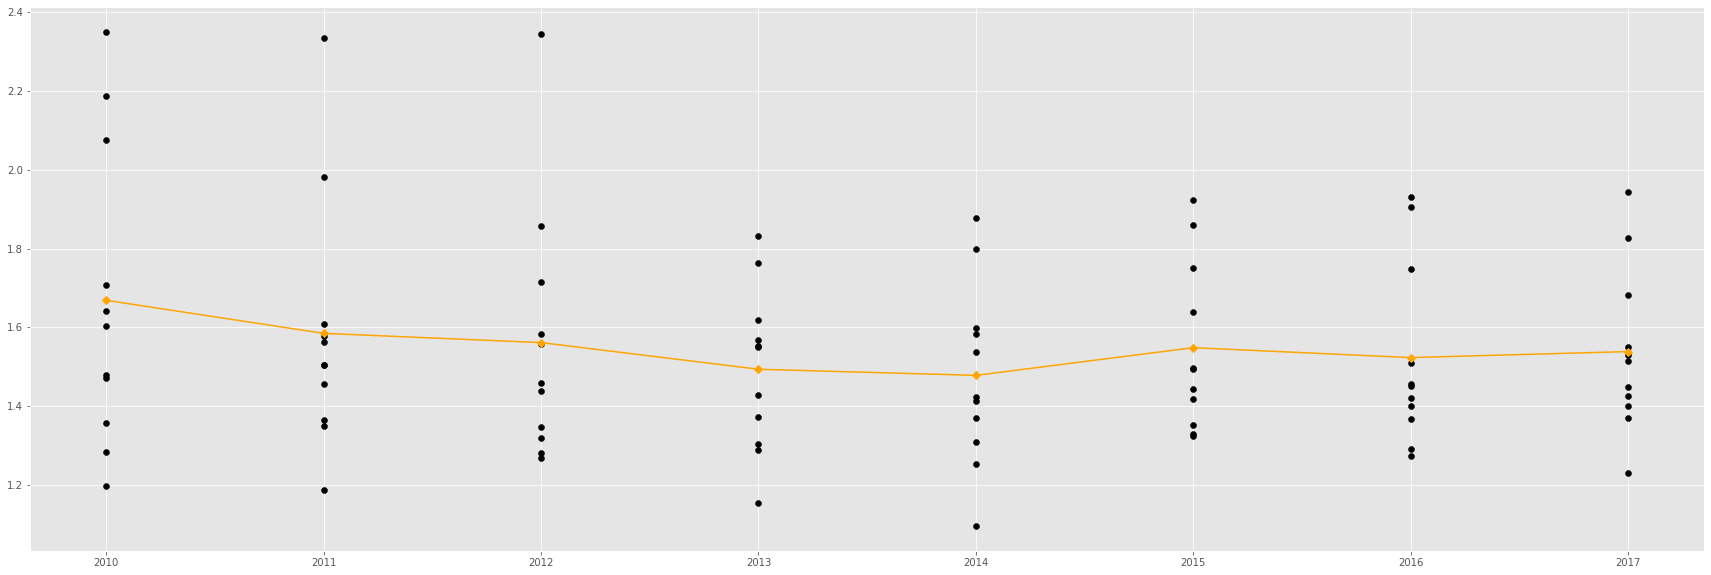

In [146]:
fig, ax = plt.subplots(figsize = (30,10))
year = np.linspace(2010, 2017, 8)

for GEOID in new_data["GEOID"].unique():
    ax.scatter(year, new_data.loc[new_data["GEOID"] == GEOID]["Mean Income / Median Income"], color = "black")


ax.plot(year, new_data[["Mean Income / Median Income", "Year_x"]].groupby(["Year_x"]).mean(), marker = "D", color="orange", label = "Average")